<a href="https://colab.research.google.com/github/AmirH-mirz/LSTM_GRU/blob/main/BBC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from zipfile import ZipFile

In [3]:
with ZipFile('/content/drive/MyDrive/BBC_text.zip', 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [4]:
import numpy as np
import pandas as pd
import os
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Embedding, LSTM, Dropout, Bidirectional ,GRU

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [5]:
data = pd.read_csv('/content/bbc_data.csv')
data

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment
...,...,...
2220,Warning over Windows Word files Writing a Mic...,tech
2221,Fast lifts rise into record books Two high-sp...,tech
2222,Nintendo adds media playing to DS Nintendo is...,tech
2223,Fast moving phone viruses appear Security fir...,tech


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    2225 non-null   object
 1   labels  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [7]:
# Check missing values
data.isna().sum().to_frame(name = 'Num. Nan')

,Num. Nan
data,0
labels,0


In [8]:
# Calculate the number of unique values and their occurrences in the 'rating' column
unique_values_count = data['labels'].nunique()
value_counts = data['labels'].value_counts()

# Display the number of unique values and their occurrences
print(f"Number of unique values in the 'labels' column: {unique_values_count}")
print("\nUnique values and their occurrences:")
value_counts

Number of unique values in the 'labels' column: 5

Unique values and their occurrences:


labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

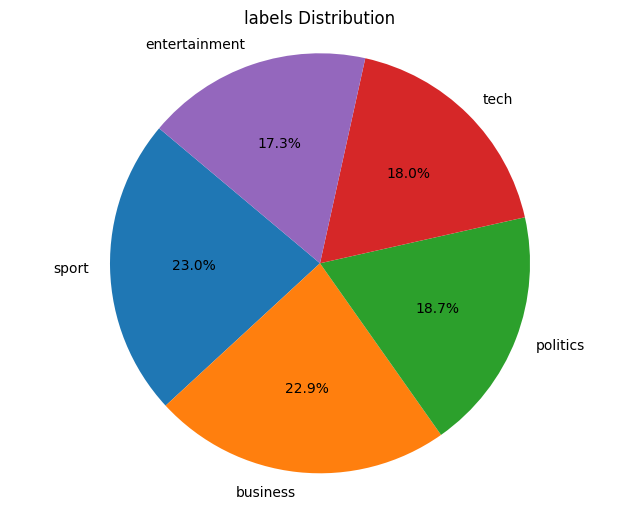

In [9]:
emotion_counts = data['labels'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('labels Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [10]:
s= {'sport': 0, 'tech': 1, 'business':2, 'politics':3, 'entertainment':4 }
data['labels'] = [s.get(i) for i in data['labels']]

In [11]:
data

,data,labels
0,Musicians to tackle US red tape Musicians gro...,4
1,"U2s desire to be number one U2, who have won ...",4
2,Rocker Doherty in on-stage fight Rock singer ...,4
3,Snicket tops US box office chart The film ada...,4
4,"Oceans Twelve raids box office Oceans Twelve,...",4
...,...,...
2220,Warning over Windows Word files Writing a Mic...,1
2221,Fast lifts rise into record books Two high-sp...,1
2222,Nintendo adds media playing to DS Nintendo is...,1
2223,Fast moving phone viruses appear Security fir...,1


In [10]:
data = data.drop_duplicates()
data.shape

(2126, 2)

In [11]:
import random

In [12]:

# Convert the 'News' column to a list
News_list = data['data'].tolist()

# Select 10 random News using random.sample
random_News = random.sample(News_list, 10)

# Print the selected News
print("\nSelected random News:")
for News in random_News:
    print(News)


Selected random News:
Orange colour clash set for court  A row over the colour orange could hit the courts after mobile phone giant Orange launched action against a new mobile venture from Easyjets founder.  Orange said it was starting proceedings against the Easymobile service for trademark infringement. Easymobile uses Easygroups orange branding. Founder Stelios Haji-Ioannou has pledged to contest the action. The move comes after the two sides failed to come to an agreement after six months of talks. Orange claims the new low-cost mobile service has infringed its rights regarding the use of the colour orange and could confuse customers - known as "passing off".  "Our brand, and the rights associated with it are extremely important to us," Orange said in a statement. "In the absence of any firm commitment from Easy, we have been left with no choice but to start an action for trademark infringement and passing off." However, Mr Haji-Ioannou, who plans to launch Easymobile next month, 

In [13]:
# Function to print before and after states
def print_before_after(step, before, after):
    print(f"\n--- {step} ---")
    for i in range(3):  # Show the first three items for brevity
        print(f"Before: {before[i]}")
        print(f"After : {after[i]}")
        print()

In [14]:
import spacy

In [15]:
# Step-by-step functions
def to_lowercase(text):
    text = text.lower()
    return text

print("Before Lowercase:")
before_step_1 = data['data'].copy()
data['data'] = data['data'].apply(to_lowercase)
print_before_after("Step 1: Trim Leading and Trailing Whitespace", before_step_1, data['data'])
print("\n")

Before Lowercase:

--- Step 1: Trim Leading and Trailing Whitespace ---
Before: Musicians to tackle US red tape  Musicians groups are to tackle US visa regulations which are blamed for hindering British acts chances of succeeding across the Atlantic.  A singer hoping to perform in the US can expect to pay $1,300 (xc2xa3680) simply for obtaining a visa. Groups including the Musicians Union are calling for an end to the "raw deal" faced by British performers. US acts are not faced with comparable expense and bureaucracy when visiting the UK for promotional purposes.  Nigel McCune from the Musicians Union said British musicians are "disadvantaged" compared to their US counterparts. A sponsor has to make a petition on their behalf, which is a form amounting to nearly 30 pages, while musicians face tougher regulations than athletes and journalists. "If you make a mistake on your form, you risk a five-year ban and thus the ability to further your career," says Mr McCune.  "The US is the worl

<ipython-input-15-339f9a7ea02d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['data'] = data['data'].apply(to_lowercase)


In [16]:
def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text)

before_step_2 = data['data'].copy()
data['data'] = data['data'].apply(remove_html_tags)

print_before_after("Step 2: Trim Leading and Trailing Whitespace", before_step_2, data['data'])


--- Step 2: Trim Leading and Trailing Whitespace ---
Before: musicians to tackle us red tape  musicians groups are to tackle us visa regulations which are blamed for hindering british acts chances of succeeding across the atlantic.  a singer hoping to perform in the us can expect to pay $1,300 (xc2xa3680) simply for obtaining a visa. groups including the musicians union are calling for an end to the "raw deal" faced by british performers. us acts are not faced with comparable expense and bureaucracy when visiting the uk for promotional purposes.  nigel mccune from the musicians union said british musicians are "disadvantaged" compared to their us counterparts. a sponsor has to make a petition on their behalf, which is a form amounting to nearly 30 pages, while musicians face tougher regulations than athletes and journalists. "if you make a mistake on your form, you risk a five-year ban and thus the ability to further your career," says mr mccune.  "the us is the worlds biggest music m

<ipython-input-16-b98fb7d6a84d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['data'] = data['data'].apply(remove_html_tags)


In [17]:
def remove_urls(text):
    text = re.sub(r'https?://\S+|www\.\S+|[^a-zA-Z\s]', '', text, flags=re.MULTILINE)
    return text

before_step_3 = data['data'].copy()
data['data'] = data['data'].apply(remove_urls)

print_before_after("Step 3: Trim Leading and Trailing Whitespace", before_step_3, data['data'])


--- Step 3: Trim Leading and Trailing Whitespace ---
Before: musicians to tackle us red tape  musicians groups are to tackle us visa regulations which are blamed for hindering british acts chances of succeeding across the atlantic.  a singer hoping to perform in the us can expect to pay $1,300 (xc2xa3680) simply for obtaining a visa. groups including the musicians union are calling for an end to the "raw deal" faced by british performers. us acts are not faced with comparable expense and bureaucracy when visiting the uk for promotional purposes.  nigel mccune from the musicians union said british musicians are "disadvantaged" compared to their us counterparts. a sponsor has to make a petition on their behalf, which is a form amounting to nearly 30 pages, while musicians face tougher regulations than athletes and journalists. "if you make a mistake on your form, you risk a five-year ban and thus the ability to further your career," says mr mccune.  "the us is the worlds biggest music m

<ipython-input-17-64db8034f880>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['data'] = data['data'].apply(remove_urls)


In [18]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Function to lemmatize text using spaCy
def lemmatize_text_spacy(text):
    doc = nlp(text)
    lemmatized_text = ' '.join([token.lemma_ for token in doc])
    return lemmatized_text

before_step_4 = data['data'].copy()
data['data']  = data['data'].apply(lemmatize_text_spacy)
print_before_after("Step 4: Remove Punctuation", before_step_4, data['data'])


--- Step 4: Remove Punctuation ---
Before: musicians to tackle us red tape  musicians groups are to tackle us visa regulations which are blamed for hindering british acts chances of succeeding across the atlantic  a singer hoping to perform in the us can expect to pay  xcxa simply for obtaining a visa groups including the musicians union are calling for an end to the raw deal faced by british performers us acts are not faced with comparable expense and bureaucracy when visiting the uk for promotional purposes  nigel mccune from the musicians union said british musicians are disadvantaged compared to their us counterparts a sponsor has to make a petition on their behalf which is a form amounting to nearly  pages while musicians face tougher regulations than athletes and journalists if you make a mistake on your form you risk a fiveyear ban and thus the ability to further your career says mr mccune  the us is the worlds biggest music market which means something has to be done about the

<ipython-input-18-eade20c3815f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['data']  = data['data'].apply(lemmatize_text_spacy)


In [19]:
before_step_5 = data['data'].copy()
translator = str.maketrans('', '', string.punctuation)
data['data']= [text.translate(translator) for text in data['data']]
print_before_after("Step 5: Remove Punctuation", before_step_5, data['data'])


--- Step 5: Remove Punctuation ---
Before: musician to tackle we red tape   musician group be to tackle we visa regulation which be blame for hinder british act chance of succeed across the atlantic   a singer hope to perform in the we can expect to pay   xcxa simply for obtain a visa group include the musician union be call for an end to the raw deal face by british performer we act be not face with comparable expense and bureaucracy when visit the uk for promotional purpose   nigel mccune from the musician union say british musician be disadvantaged compare to their us counterpart a sponsor have to make a petition on their behalf which be a form amount to nearly   page while musician face tough regulation than athlete and journalist if you make a mistake on your form you risk a fiveyear ban and thus the ability to further your career say mr mccune   the us be the world big music market which mean something have to be do about the creaky bureaucracy say mr mccune the current situatio

<ipython-input-19-60522448e1ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['data']= [text.translate(translator) for text in data['data']]


In [20]:
def remove_extra_spaces(text):
    text = re.sub(r'\s+', ' ', text).strip()
    return text

before_step_6 = data['data'].copy()
data['data']  = data['data'].apply(remove_extra_spaces)
print_before_after("Step 4: Remove Punctuation", before_step_6, data['data'])


--- Step 4: Remove Punctuation ---
Before: musician to tackle we red tape   musician group be to tackle we visa regulation which be blame for hinder british act chance of succeed across the atlantic   a singer hope to perform in the we can expect to pay   xcxa simply for obtain a visa group include the musician union be call for an end to the raw deal face by british performer we act be not face with comparable expense and bureaucracy when visit the uk for promotional purpose   nigel mccune from the musician union say british musician be disadvantaged compare to their us counterpart a sponsor have to make a petition on their behalf which be a form amount to nearly   page while musician face tough regulation than athlete and journalist if you make a mistake on your form you risk a fiveyear ban and thus the ability to further your career say mr mccune   the us be the world big music market which mean something have to be do about the creaky bureaucracy say mr mccune the current situatio

<ipython-input-20-5443c6780e9a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['data']  = data['data'].apply(remove_extra_spaces)


In [21]:
abbreviation_dict = {
    "pls": "please",
    "u": "you",
    "ur": "your",
    "r": "are",
    "btw": "by the way",
    "idk": "i don't know",
    "tbh": "to be honest",
    "brb": "be right back",
    "lol": "laugh out loud",
    "omg": "oh my god",
    "thx": "thanks",
    "np": "no problem",
}

In [22]:
# Define a function to expand abbreviations in a string
def expand_abbreviations(text):
    words = text.split()
    expanded_words = [abbreviation_dict.get(word, word) for word in words]
    expanded_text = ' '.join(expanded_words)
    return expanded_text

before_step_7 = data['data'].copy()
data['data']  = data['data'].apply(expand_abbreviations)
print_before_after("Step 4: Remove Punctuation", before_step_7, data['data'])


--- Step 4: Remove Punctuation ---
Before: musician to tackle we red tape musician group be to tackle we visa regulation which be blame for hinder british act chance of succeed across the atlantic a singer hope to perform in the we can expect to pay xcxa simply for obtain a visa group include the musician union be call for an end to the raw deal face by british performer we act be not face with comparable expense and bureaucracy when visit the uk for promotional purpose nigel mccune from the musician union say british musician be disadvantaged compare to their us counterpart a sponsor have to make a petition on their behalf which be a form amount to nearly page while musician face tough regulation than athlete and journalist if you make a mistake on your form you risk a fiveyear ban and thus the ability to further your career say mr mccune the us be the world big music market which mean something have to be do about the creaky bureaucracy say mr mccune the current situation be prevent

<ipython-input-22-982a76695ee4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['data']  = data['data'].apply(expand_abbreviations)


In [38]:
df = pd.DataFrame(data)
df

,data,labels
0,musician to tackle we red tape musician group ...,entertainment
1,we desire to be number one you who have win th...,entertainment
2,rocker doherty in onstage fight rock singer pe...,entertainment
3,snicket top us box office chart the film adapt...,entertainment
4,ocean twelve raid box office ocean twelve the ...,entertainment
...,...,...
2220,warn over windows word file write a microsoft ...,tech
2221,fast lift rise into record book two highspeed ...,tech
2222,nintendo add medium play to ds nintendo be rel...,tech
2223,fast move phone virus appear security firm be ...,tech


In [39]:
texts = df['data'].values
labels = df['labels'].values

#train, validation, and test split
x_train, x_val, y_train, y_val = train_test_split(texts, labels, test_size=0.3, random_state=42, shuffle=True, stratify=None)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42, shuffle=True, stratify=None)

In [88]:
# vectorized = np.vectorize()
# x_train = vectorized(x_train)
# x_test = vectorized(x_test)
# x_val = vectorized(x_val)

In [89]:
# vectorizer = CountVectorizer()
# x_train = vectorizer.fit_transform(x_train)
# x_test = vectorizer.transform(x_test)
# x_val = vectorizer.transform(x_val)

In [30]:
from keras.utils import to_categorical

In [41]:
from sklearn.preprocessing import LabelEncoder

In [40]:
# Tokenization
tokenizer = Tokenizer(num_words=1000, oov_token='<oov>')
tokenizer.fit_on_texts(x_train)
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Padding sequences
max_length = max(len(sequence) for sequence in x_train_seq)
x_train_pad = pad_sequences(x_train_seq, maxlen=max_length, padding='post', truncating='post')
x_val_pad = pad_sequences(x_val_seq, maxlen=max_length, padding='post', truncating='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_length, padding='post', truncating='post')

In [87]:
# y_tokenizer = Tokenizer()
# y_tokenizer.fit_on_texts(y_train)
# y_train_seq = np.array(y_tokenizer.texts_to_sequences(y_train))
# y_test_seq = np.array(y_tokenizer.texts_to_sequences(y_test))
# y_val_seq = np.array(y_tokenizer.texts_to_sequences(y_val))
# print(y_test_seq[:5])
# print(np.unique(y_test_seq))

In [42]:
# Encode labels to integers
label_encoder = LabelEncoder()
y_train_int = label_encoder.fit_transform(y_train)
y_val_int = label_encoder.transform(y_val)
y_test_int = label_encoder.transform(y_test)

# Convert integer labels to categorical
y_train_cat = to_categorical(y_train_int, num_classes=len(label_encoder.classes_))
y_val_cat = to_categorical(y_val_int, num_classes=len(label_encoder.classes_))
y_test_cat = to_categorical(y_test_int, num_classes=len(label_encoder.classes_))

# **LSTM**

In [27]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [28]:
# Define the EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,           # Stop training if no improvement for 8 consecutive epochs
    restore_best_weights=True  # Restore best weights based on validation loss
)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    min_lr=1e-6)

In [61]:
# Define model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
##LSTM = dropout=0.2, recurrent_dropout=0.2##
model = Sequential([
    Input(shape=(max_length,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, trainable=False),
    Bidirectional(LSTM(units=128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(units=512, activation='relu'),
    Dropout(rate=0.5),
    Dense(units=5, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 4431, 300)         6408900   
                                                                 
 bidirectional_13 (Bidirect  (None, 4431, 256)         439296    
 ional)                                                          
                                                                 
 bidirectional_14 (Bidirect  (None, 128)               164352    
 ional)                                                          
                                                                 
 dense_22 (Dense)            (None, 512)               66048     
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_23 (Dense)            (None, 5)               

In [62]:
history = model.fit(x=x_train_pad, y=y_train_cat, epochs=20,
                    validation_data=(x_val_pad, y_val_cat),
                    callbacks=[early_stopping, lr_scheduler])


Epoch 1/15
47/47 [==============================] - 35s 602ms/step - loss: 1.5718 - accuracy: 0.2708 - val_loss: 1.4936 - val_accuracy: 0.3417 - lr: 0.0010
Epoch 2/15
47/47 [==============================] - 27s 578ms/step - loss: 1.4351 - accuracy: 0.3730 - val_loss: 1.3653 - val_accuracy: 0.3950 - lr: 0.0010
Epoch 3/15
47/47 [==============================] - 27s 572ms/step - loss: 1.2113 - accuracy: 0.4980 - val_loss: 1.0455 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 4/15
47/47 [==============================] - 27s 584ms/step - loss: 0.9874 - accuracy: 0.5833 - val_loss: 1.0602 - val_accuracy: 0.5329 - lr: 0.0010
Epoch 5/15
47/47 [==============================] - 27s 583ms/step - loss: 0.8876 - accuracy: 0.6465 - val_loss: 0.9122 - val_accuracy: 0.6082 - lr: 0.0010
Epoch 6/15
47/47 [==============================] - 27s 584ms/step - loss: 0.8068 - accuracy: 0.6962 - val_loss: 0.8997 - val_accuracy: 0.6395 - lr: 0.0010
Epoch 7/15
47/47 [==============================] - 27s 577ms/st

In [81]:
# Predict the labels for the training and validation sets
y_train_pred = model.predict(x_train_pad)
y_test_pred = model.predict(x_test_pad)

# Convert the predictions and true labels to class labels (from one-hot encoding)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = np.argmax(y_train_cat, axis=1)

y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test_cat, axis=1)

# Calculate the accuracy for both training and validation sets
train_accuracy = accuracy_score(y_train_true_classes, y_train_pred_classes) * 100
test_accuracy = accuracy_score(y_test_true_classes, y_test_pred_classes) * 100

# Print the accuracies in the desired format
print(f'Train Accuracy : {train_accuracy:.2f} %')
print(f'Test Accuracy  : {test_accuracy:.2f} %')

10/10 [==============================] - 2s 207ms/step
Train Accuracy : 90.99 %
Test Accuracy  : 77.12 %


In [ ]:
plt.figure(figsize = (12, 6))

# loss plot

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# accuracy plot

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [82]:
# Generate the confusion matrix
cm = confusion_matrix(y_test_true_classes, y_test_pred_classes)

print(classification_report(y_test_true_classes, y_test_pred_classes))

              precision    recall  f1-score   support

           0       0.66      0.96      0.78        85
           1       0.86      0.75      0.80        64
           2       0.79      0.65      0.71        63
           3       0.93      0.74      0.83        58
           4       0.80      0.65      0.72        49

    accuracy                           0.77       319
   macro avg       0.81      0.75      0.77       319
weighted avg       0.80      0.77      0.77       319



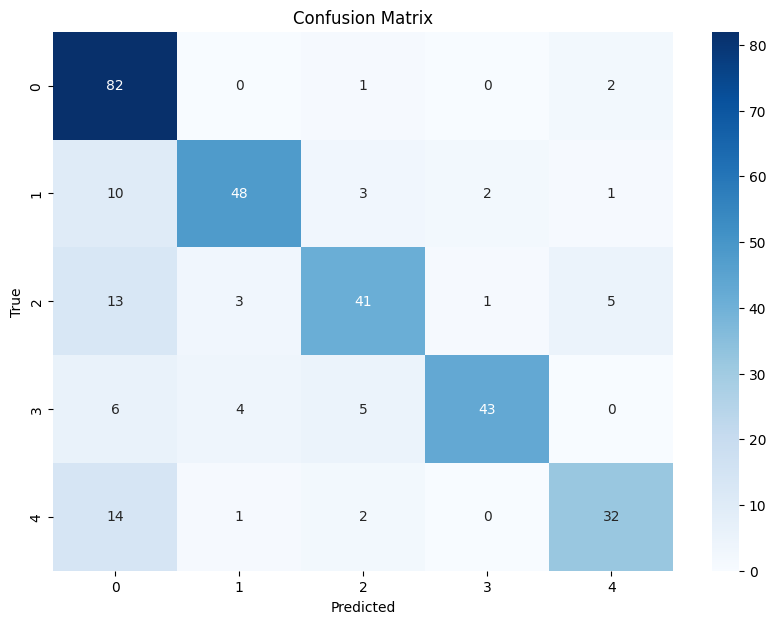

In [83]:
class_names = [0, 1, 2, 3, 4]

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# **GRU**

In [65]:
# Define model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300

model_GRU = Sequential([
    Input(shape=(max_length,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, trainable=False),
    Bidirectional(GRU(units=128,return_sequences=True)),
    Bidirectional(GRU(64)),
    Dense(units=512, activation='relu'),
    Dropout(rate=0.5),
    Dense(units=5, activation='softmax')
])

# Compile the model
model_GRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model_GRU.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 4431, 300)         6408900   
                                                                 
 bidirectional_17 (Bidirect  (None, 4431, 256)         330240    
 ional)                                                          
                                                                 
 bidirectional_18 (Bidirect  (None, 128)               123648    
 ional)                                                          
                                                                 
 dense_26 (Dense)            (None, 512)               66048     
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 5)               

In [66]:
history = model_GRU.fit(x=x_train_pad, y=y_train_cat, epochs=15,
                    validation_data=(x_val_pad, y_val_cat),
                    callbacks=[early_stopping, lr_scheduler])


Epoch 1/15
47/47 [==============================] - 36s 599ms/step - loss: 1.5608 - accuracy: 0.2970 - val_loss: 1.4882 - val_accuracy: 0.3103 - lr: 0.0010
Epoch 2/15
47/47 [==============================] - 26s 558ms/step - loss: 1.4803 - accuracy: 0.3582 - val_loss: 1.4243 - val_accuracy: 0.3636 - lr: 0.0010
Epoch 3/15
47/47 [==============================] - 28s 606ms/step - loss: 1.3808 - accuracy: 0.4099 - val_loss: 1.3202 - val_accuracy: 0.4608 - lr: 0.0010
Epoch 4/15
47/47 [==============================] - 27s 569ms/step - loss: 1.1969 - accuracy: 0.4966 - val_loss: 1.1763 - val_accuracy: 0.4796 - lr: 0.0010
Epoch 5/15
47/47 [==============================] - 30s 639ms/step - loss: 1.0177 - accuracy: 0.6001 - val_loss: 1.0849 - val_accuracy: 0.5737 - lr: 0.0010
Epoch 6/15
47/47 [==============================] - 26s 552ms/step - loss: 0.8337 - accuracy: 0.6767 - val_loss: 0.8971 - val_accuracy: 0.6646 - lr: 0.0010
Epoch 7/15
47/47 [==============================] - 26s 554ms/st

In [84]:
# Predict the labels for the training and validation sets
y_train_pred = model_GRU.predict(x_train_pad)
y_test_pred = model_GRU.predict(x_test_pad)

# Convert the predictions and true labels to class labels (from one-hot encoding)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = np.argmax(y_train_cat, axis=1)

y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test_cat, axis=1)

# Calculate the accuracy for both training and validation sets
train_accuracy = accuracy_score(y_train_true_classes, y_train_pred_classes) * 100
test_accuracy = accuracy_score(y_test_true_classes, y_test_pred_classes) * 100

# Print the accuracies in the desired format
print(f'Train Accuracy : {train_accuracy:.2f} %')
print(f'Test Accuracy  : {test_accuracy:.2f} %')

10/10 [==============================] - 4s 359ms/step
Train Accuracy : 97.04 %
Test Accuracy  : 77.74 %


In [85]:
# Generate the confusion matrix
cm = confusion_matrix(y_test_true_classes, y_test_pred_classes)

print(classification_report(y_test_true_classes, y_test_pred_classes))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82        85
           1       0.76      0.75      0.76        64
           2       0.69      0.68      0.69        63
           3       0.88      0.90      0.89        58
           4       0.74      0.69      0.72        49

    accuracy                           0.78       319
   macro avg       0.77      0.77      0.77       319
weighted avg       0.78      0.78      0.78       319



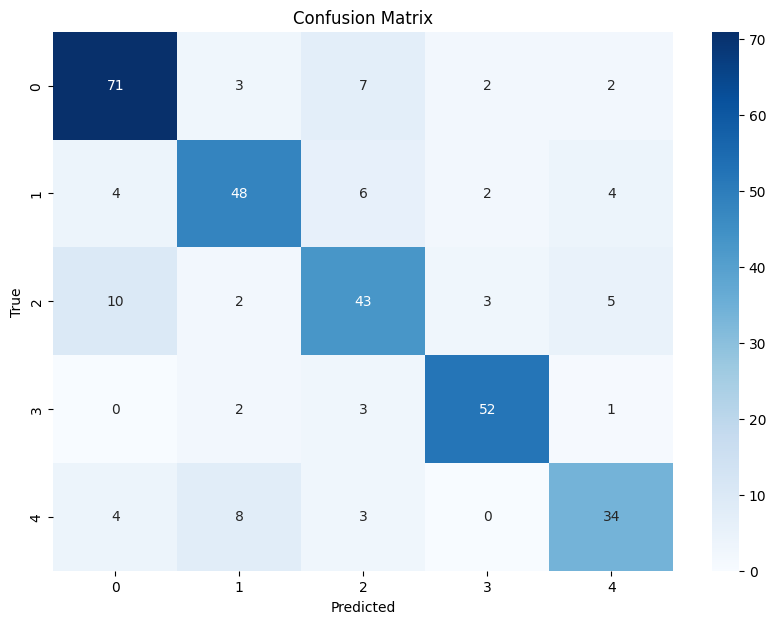

In [86]:
class_names = [0, 1, 2, 3, 4]

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()